# Final

_May 07 2025 | Chen Kai Zhang | 014806701_

## Introduction

This final project will investigate whether common economic indicators can improve stock price forecasting in the NASDAQ market. 

_**Will reading common enconomic indicators help with predicting the future forecast of stock prices more accurately?**_

As a day trader, I am motivated to explore this topic to enhance my trading strategy. Identifying correlations between economic indicators and stock prices could lead to more confident and profitable trades.

While day trading is not for everyone, I strongly believe that a deep understanding of the market, the common lingo, and tools, will only have positive impacts on individuals. Having more knowledge of the market will lead to better investment strategies, allowing people to build wealth over time.

Of course this topic is nothing new. Research in the past such as the one conducted my Nal-Fu Chen, Richard Roll, and Stephen A Ross have shown that some economic indicators like interest rates and stock returns have correlation. In addition, many machine learning models have been developed to attempt to further improve market predictions. However, I think of this study as great stepping stone to understand how I can personally tackle this challenge, making it more exciting.

## Data

For a more in-depth analysis please revist the **project_proposal.ipynb** file.

**Dataset Overview**

- **Source** : [Kaggle NASDAQ Dataset](https://www.kaggle.com/datasets/sai14karthik/nasdq-dataset)
- **Author** : Sai Karthik
- **Data Collection** :
  - **Yahoo Finance** : historical stock prices
  - **Federal Reserve Economic Data (FRED)** : economic indicators (interest rates, VIX, etc)
  - **Alpha Vantage** : gold and oil prices
- **Study Type** : observational 

The Kaggle dataset that we will be exploring contains common economic factor (feature) statistics spanning from **January 01 2010** to **October 24 2024**. Each row represents the statistic of each feature at every day between those dates. Below is the list of features present in the dataset.

- Date : date format in YYYY-MM-DD (string)
- Open : price stock opened at (float USD)
- Close : price stock closed at (float USD)
- High : highest price stock achieved (float USD)
- Low : lowest price stock achieved (float USD)
- Volume : shares traded (.00 float)
- Interest Rate : prevailing interest rate (float)
- Exchange Rate : exchange rate for USD against other currencies (float)
- VIX : measure of market risk (float)
- Gold : gold price (float USD)
- Oil : oil price (float USD)
- TED Spread : banking system credit risk (float)
- EFFR : interest rates between depository institutions (float)

For this study we will be focused on :

- Close
- Volume
- Interest Rate
- Exchange Rate
- VIX

Of course, I will be exploring the other features as well simply due to interests.

Before I begin exploring the data, I coducted some data quality checks. Most notibly :

- Date continuity
- Feature correlations
- Outliers

Below I've included some code and visualization, that I find to be the most important.

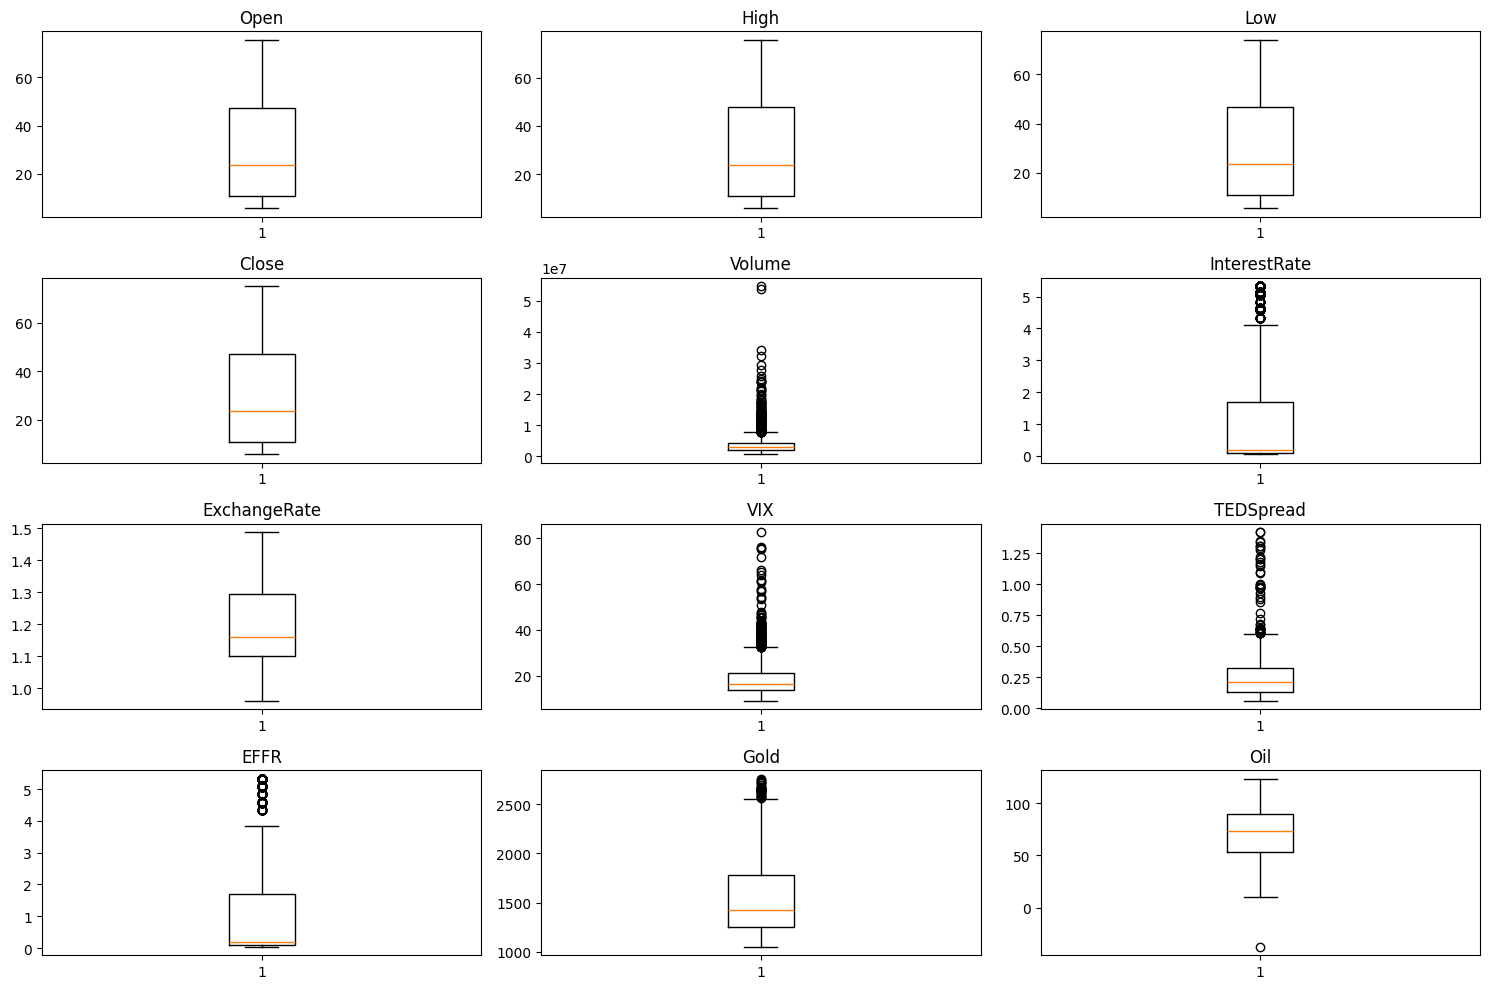

<Axes: >

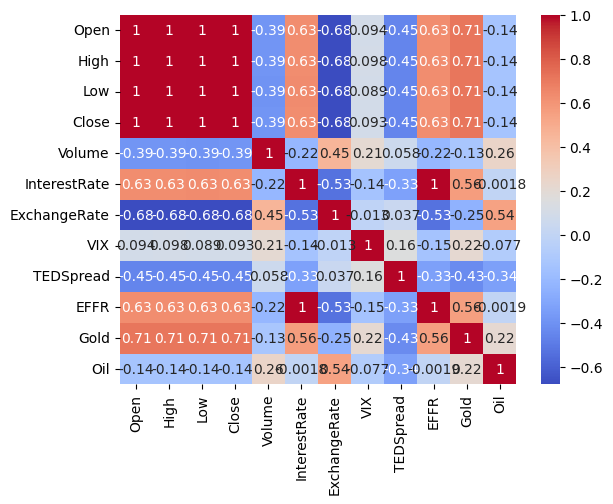

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "./datasets/nasdaq.csv"

nasdaq_df = pd.read_csv(dataset_path)

def show_outliers(df):
    plt.figure(figsize=(15,10))
    for i, col in enumerate(df.columns, 1):
        plt.subplot(4, 3, i)
        plt.boxplot(df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()
  
# Show outliers
show_outliers(nasdaq_df.select_dtypes(["float64"]))

# Show the correlation between features in a heatmap
sns.heatmap(nasdaq_df.select_dtypes(['float64']).corr(), annot=True, cmap="coolwarm")

The two observations above led to the two main data clean-up I performed :

1. Capping outliers via IQR
2. Selecting one feature between `open`, `high`, `low`, and `close` since they were way too correlated

Through the heatmap, I did also notice that there were some closly correlated features, but I chose to ignore them since they were either not too correlated for me to be determine it as an issue or just wasn't a feature I was interested in the first place.

## Exploratory Data Analysis

For a more in-depth analysis please revist the **exploratory_data_analysis.ipynb** file.

In the original EDA notebook, I had presented 4 questions that I had wanted to answer through this process. Although they were individually unique, they were all in an attempt to answer the goal of this study : _**Will reading common economic indicators help with predicting the future forecast of stock prices more accurately?**_

In that analysis, I presented 2 main figures, reproduced via the code below.

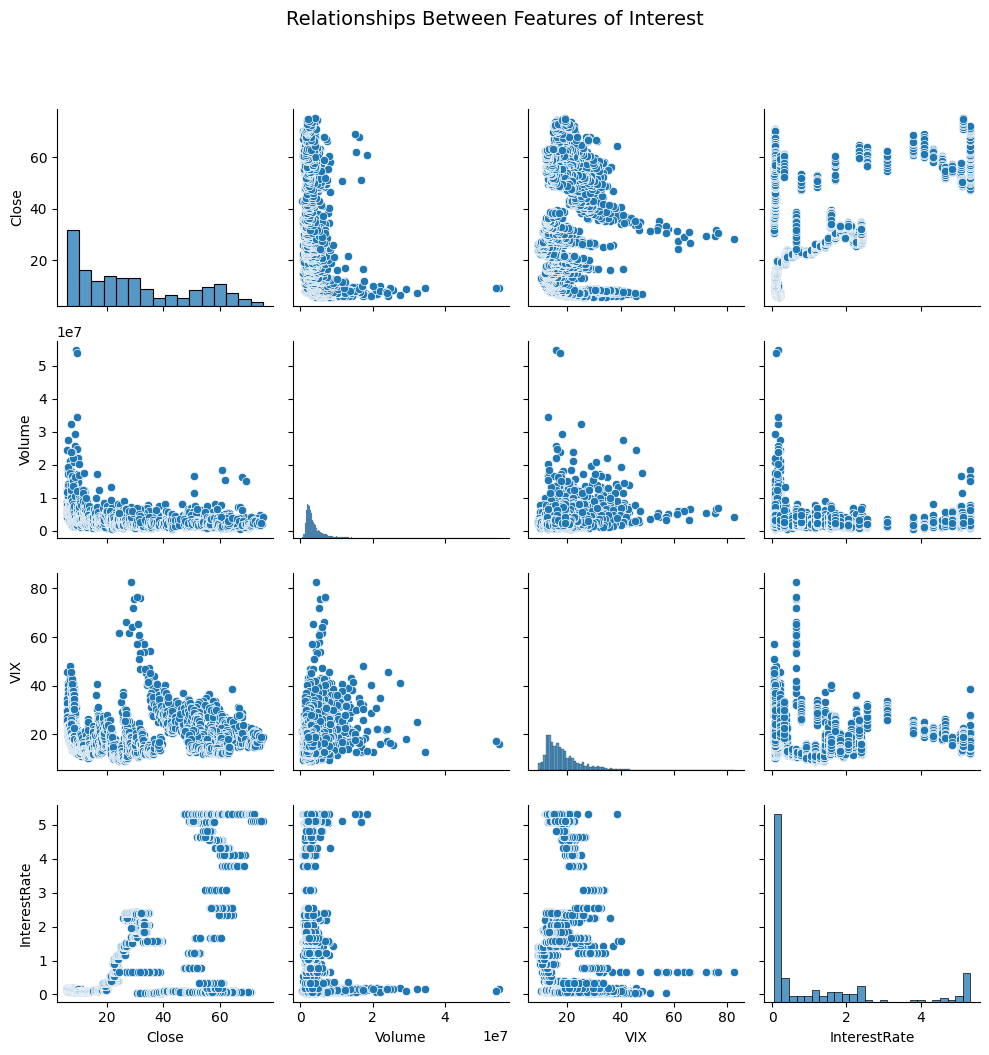

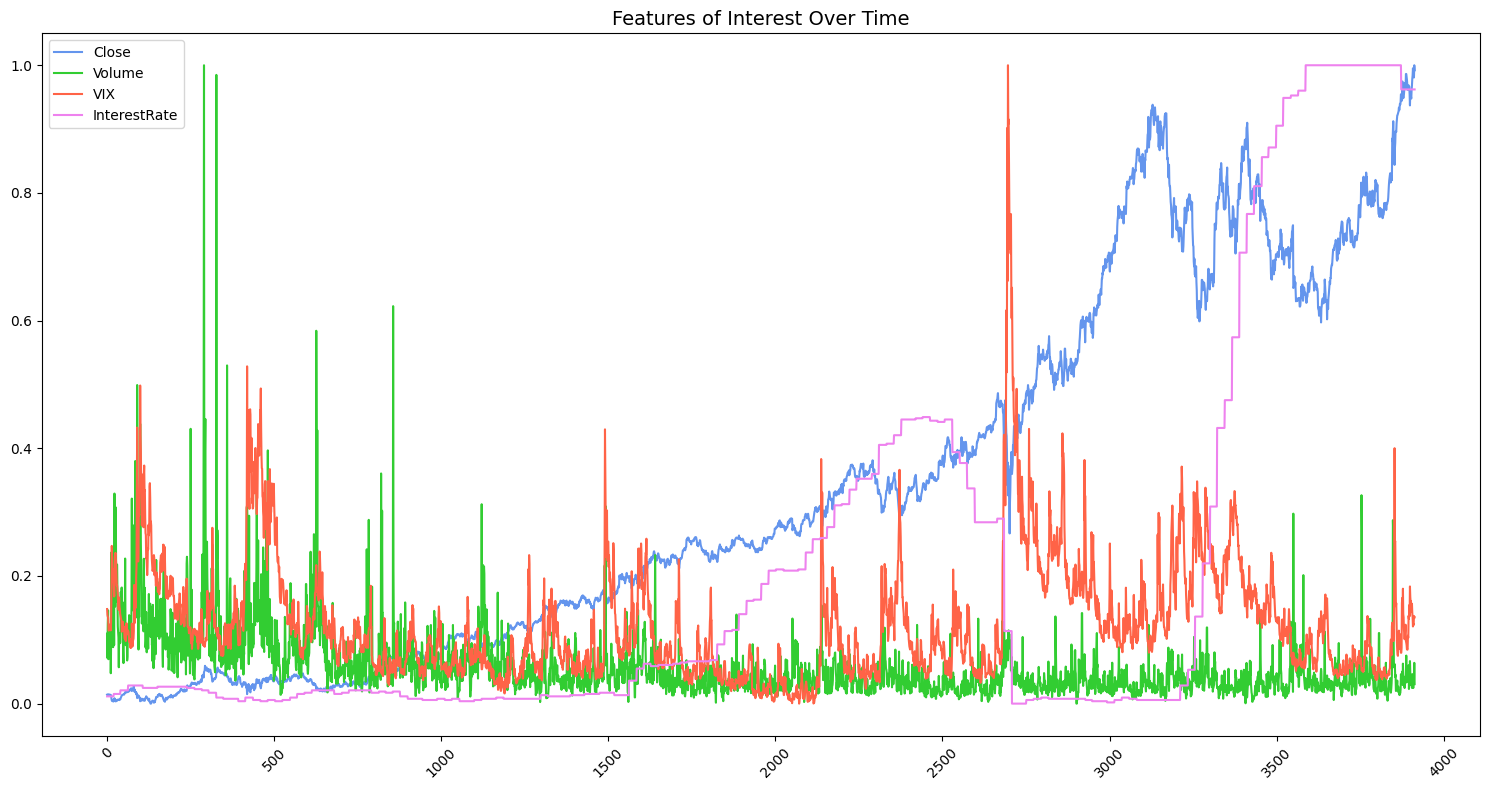

In [2]:
key_columns = ["Close", "Volume", "VIX", "InterestRate"]
colors = ["cornflowerblue", "limegreen", "tomato", "violet"]

pair_plot = sns.pairplot(nasdaq_df[key_columns])
pair_plot.figure.suptitle("Relationships Between Features of Interest", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

nasdaq_norm_df = nasdaq_df[key_columns].copy()

for column in key_columns:
    nasdaq_norm_df[column] = (nasdaq_df[column] - nasdaq_df[column].min()) / (nasdaq_df[column].max() - nasdaq_df[column].min())

plt.figure(figsize=(15,8))
for key, color in zip(key_columns, colors):
    plt.plot(nasdaq_norm_df.index, nasdaq_norm_df[key], label=key, color=color, linewidth=1.5)

plt.title("Features of Interest Over Time", fontsize=14)
plt.legend(loc="upper left")
plt.xticks(rotation=45)  # Rotate x-axis labels


plt.tight_layout()
plt.show()

For simplicity sake, I will refer the first diagram as D1 and the second one as D2. 

**D1**

This diagram showed the correlation between feature more closely. From D1, we can see that the only relationship that has some form of presence is the one between `close` and `interest rate`. Althought minute, you can see a clear positive trend where as the close prices tend to have a higher min max range at higher interest rate levels.

**D2**

This diagram plots the features over time, which strengthens the point that our features don't really share a relationship between one another. We see the weak relationship observed in D1 between `close` (blue) and `interest rate` (purple), but all other features of interest seem to be very independent.

Since the analysis has demonstrated that common economic indicators have little to minor influence on the closing price of stock prices, it suggests that they are not good indicators for predicting the future forecast of stock prices.

## Inference

The two techniques I will be applying to help further confirmation of the EDA results will be **hypothesis testing** and **linear regression**. With these two tests, I will be able to determine :

- Identify if any specific indicator correlates to significant movement in stock prices (hypothesis testing)
- Will economic indicators predict stock prices and if so, their predictive power (linear regression)

I will go over both techniques in more detail individually.


### Hypothesis Testing

Hypotheiss testing will help me evaluate whether economic inidcators correlates to significant movement in stock prices.

**Formulation**

To accomplish this we will be testing the null hypothesis ($H_0$) : "The correlation between interest rates and closing price is 0" against the alternative ($H_a$) : "The correlation is non-0". 



We will conduct this testing via the code below.

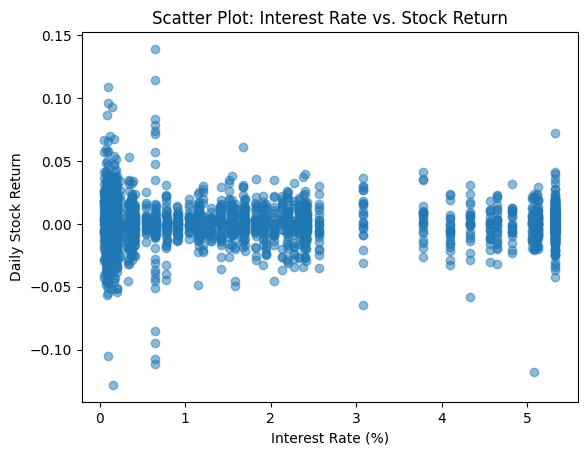

Spearman Correlation Coefficient: -0.0058
P-value: 0.7166
Fail to reject H0: No significant monotonic correlation (p >= 0.05).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

dataset_path = "./datasets/nasdaq.csv"
nasdaq_df = pd.read_csv(dataset_path)

# Calculate daily stock returns
nasdaq_df['Return'] = nasdaq_df['Close'].pct_change().shift(-1)  # Shift to align with next day's return

# Drop missing values
nasdaq_df = nasdaq_df[['Return', 'InterestRate']].dropna()

# Assumption Check: Monotonicity (visual inspection via scatter plot)
plt.scatter(nasdaq_df['InterestRate'], nasdaq_df['Return'], alpha=0.5)
plt.xlabel('Interest Rate (%)')
plt.ylabel('Daily Stock Return')
plt.title('Scatter Plot: Interest Rate vs. Stock Return')
plt.show()

# Hypothesis Testing: Spearman Correlation
correlation, p_value = spearmanr(nasdaq_df['InterestRate'], nasdaq_df['Return'])
print(f"Spearman Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"Reject H0: Significant monotonic correlation between interest rates and stock returns (p < {alpha}).")
else:
    print(f"Fail to reject H0: No significant monotonic correlation (p >= {alpha}).")

**Assumption Checks**

Spearman's correlation assumes a monotonic relationship between interest rates and stock returns (-0.0058), showing that thier correlation is little to negiligble. To verify this calculation, I have shown a scatter plot of the relationship between the two values. Through visual inspection of the scatter plot, we see that there is no consistent upward or downward pattern as interest increases, aligning with our Spearman correlation, thus supporting the conclusion that interest rates are unlikely to improve stock prices forcasting.

**Validation**

This approach should be valid due to two main reasons :

1. We used the full dataset
2. We used a threshold of $\alpha = 0.05$

By using the full dataset, we are leveraging all the available data. With over 3.5K observations, there is increaed reliability and reduction to the standard error of the correlation estimate, making the test more sensitive to detecting a true correlation if exists (which is did not). In addition, by setting the threshold to $\alpha = 0.05$, we ensure that our conclusion is based on an accepted criterion, and not adjusted for individual benefit.

**Interpretation**

The Spearman's correlation reported a $-0.0058$, indicating a negligible, but negative relationship. In addition with a p-value of $0.7166$, $H_0$ was failed to be reject. These two results suggests that there is no significant monotonic correlation between interest rates and stock returns, implying that from our observations in EDA, the challenges of predicting stock prices may require more information than common ecomonic indicators.

### Linear Regression

The linear regression test will allow me to model the relationship between multiple indicators and stock returns

**Formulation**

The general formula we will be following is ...

$$Return_t = \beta_0 + \beta_1 \times feature_{1t} ... \beta_n \times feature_{nt} + \epsilon_t$$

... where :

- $Return_t$ : the daily stock return at time $t$
- $\beta_0$ : intercept
- $\beta_n$ : coefficients for each predictor (feature)
- $\epsilon_t$ : error term

Alongside our formula, we will be testing the following hypothesis :

- $H_0$ : All $\beta_n = 0$
- $H_a$ : At least one $\beta ≠ 0$ 

The testing will be conducted via the code below.

R-squared: -0.0259
Adjusted R-squared: -0.0312


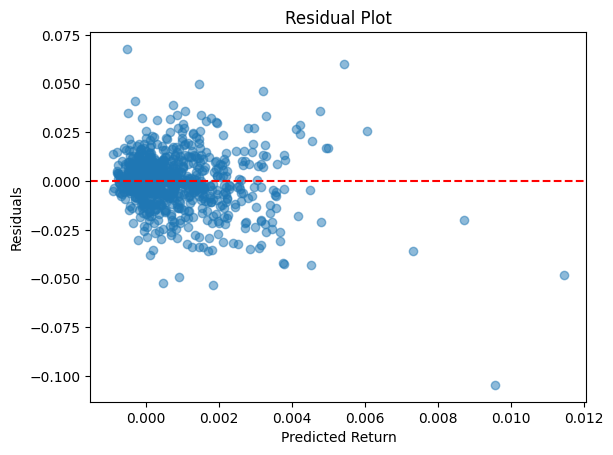

Shapiro-Wilk p-value for residuals: 0.0000
Normality of residuals violated.
Durbin-Watson statistic: 2.0167
No significant autocorrelation (DW near 2).


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

dataset_path = "./datasets/nasdaq.csv"
nasdaq_df = pd.read_csv(dataset_path)

# Calculate daily stock returns
nasdaq_df['Return'] = nasdaq_df['Close'].pct_change().shift(-1)
nasdaq_df = nasdaq_df.dropna()

# Predictors and targets
X = nasdaq_df[['InterestRate', 'VIX', 'ExchangeRate', 'Volume']]
y = nasdaq_df['Return']

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model fit
model = LinearRegression()
model.fit(X_train, y_train)

# Model predictions
y_pred = model.predict(X_test)

# Model performance
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

# Linearity check
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Return')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Normality check
_, p_residuals = shapiro(residuals)
print(f"Shapiro-Wilk p-value for residuals: {p_residuals:.4f}")
if p_residuals > 0.05:
    print("Normality of residuals satisfied (p > 0.05).")
else:
    print("Normality of residuals violated.")

# Autocorrelation
train_residuals = y_train - model.predict(X_train)
dw_stat = durbin_watson(train_residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")
if 1.5 <= dw_stat <= 2.5:
    print("No significant autocorrelation (DW near 2).")
else:
    print("Warning: Potential autocorrelation detected.")



**Assumption Checks**

The linear regression model assumed a linear relationship between economic indicators and daily stock returns. This assumption is verified by the scatter plot where the majority of the data points reside near 0. However, the wide spread does show signs of poor fit, showing signs of weak linearity. 

Normality of residuals was tested with the Shapiro-Wilk test, yielding a p-value of $0$, indicating a violation of the normality assumption. This suggests that the model's residuls are not normally distributed, most likely due to outliers or the weak linear relationship discussed above. 

Autocorrelation was evaluated with the Durbin-Watson statistic which received a score of around $2$, suggesting that there is no significant autocorrelation in the residuals, indicating that most, if not all of them are independent over time.

**Validation**

This linear regression test was setup using commonly accepted criterions. The model was trained and tested on a 80:20 split, which resulted in around 3K worth of training data and 750 worth of testing data. We also used the standard $\alpha = 0.05$ as our threshold for p-value validation.

The $R^2$ value was both low and negative, indicating that there was poor fit and little to no predictive power from the selected indicators. This results suggests that more tuning to the model or dataset is required for reliablility.

Although the setup for this test ensured that the model leverage all the available data when training and that the threshold was not adjusted to our favor, the extermely low $R^2$ suggests that the dataset and the model are not a good fit for one another.



**Interpretation**

The linear regression test aimed to determine if economic indicators can improve the accuracy of stock price forcasting. From the results above we saw two major issues :

1. Low $R^2$
2. Failure in Spearman correlation

The low $R^2$ indicated to us that the model failed to explain any vairance in the daily stock returns and actually performs worse than a simple mean prediction. This behavior suggests that the selected economic indicators fail to be reliable basis for predicting stock movement in our dataset. In addition, with the failure in Spearman correlation result, further supports that the provided economic indicators in this dataset fail to be reliable basis for predicting stock prices. 

## Conclusion

The results of this study indicates that common economic indicators (at least the one present) are unreliable for predicting the forecast of stock movements. Despite these unsatisfactory outcomes, the stufy has been a valuable learning experience, exposing me to multiple data exploration techniques beyond simply training and tesing models which are time consuming. Although the study fell short of its goal, I recognize that it may not have been conducted in the most optimal way due to the limitations of the curriculum. The time allocated for this project (and other course work combined) meant little time to incorporate a broader range of data such as additional indicators or higher-frequency observations. In addition, due to SJSU's rule on keeping techniques limited to the topics covered, I was unable to explore more advance machine learning techniques that could potentially lead to better prediction results. Move foreward, I am eager to extend this research by leveraging more advanced machine learning models and techniques alongside the integration of daily news sentiment as an additional indicator alongside economic factors since from personal experience, the market often refelcts the public's sentiment.